# Neighborhood Modeling

TBD

# Summary

TBD

In [5]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from scipy.fft import fft, fftfreq, fftshift
import scipy
import itertools
from ast import literal_eval

# Set style
plt.style.use('seaborn')

In [6]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics, plot_results

In [7]:
# Modeling

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest

from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [21]:
def run_model(results, df_preds_, neighborhood, ts, order, seasonal_order, logged):
    
    '''
    Docstring here. This will be a long one.
    '''
    
    train = ts[ts['future'] == 0]
    test = ts[ts['future'] == 1]

    
    if logged:
        sari_model = SARIMAX(train['ride_count_log'], order=order, seasonal_order=seasonal_order).fit(maxiter=1000)
    else:
        sari_model = SARIMAX(train['ride_count'], order=order, seasonal_order=seasonal_order).fit(maxiter=1000)
    
    # Add preds to predictions DataFrame
    preds = sari_model.forecast(steps = len(test))
    if logged:
        df_preds_.loc[:,neighborhood] = np.exp(preds)
    else:
        df_preds_.loc[:,neighborhood] = preds
    
    # Retrieve metrics
    if logged:
        model_results = report_metrics(test['ride_count'], np.exp(preds), False)
    else:
        model_results = report_metrics(test['ride_count'], preds, False)
    
    # Calculate actual vs. predicted rides for 2021
    actual_rides_2021 = ts[ts.index > '12/31/2020']['ride_count'].sum()
    pred_rides_2021 = df_preds[df_preds.index > '12/31/2020'][neighborhood].sum()
    
    ride_delta = np.abs(pred_rides_2021 - actual_rides_2021)
    
    # Add results to results dataframe
    results.loc[neighborhood, 'model'] = sari_model
    results.loc[neighborhood, 'order'] = order
    results.loc[neighborhood, 'seasonal_order'] = seasonal_order
    results.loc[neighborhood, 'explained_variance'] = model_results[0]
    results.loc[neighborhood, 'MAE'] = model_results[1]
    results.loc[neighborhood, 'MSE'] = model_results[2]
    results.loc[neighborhood, 'R2'] = model_results[3]
    results.loc[neighborhood, '2021_actual'] = actual_rides_2021
    results.loc[neighborhood, '2021_predicted'] = pred_rides_2021
    results.loc[neighborhood, 'delta'] = ride_delta
    
    return results, df_preds_

In [9]:
# Import clean dataset

df_citibike = pd.read_csv('./../clean_data/final_clean_ridership.csv', low_memory=False)

# Convert starttime to date and set as index

df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])

df_citibike.set_index('starttime', inplace=True)

# Create the daily file

daily_ridership = df_citibike[['ride_count']].resample('1D').sum()

# Filter for only data prior to 5/1/2021 (logic for this is in the EDA notebook)
# daily_ridership = daily_ridership[daily_ridership.index < '2021-06-01']

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

In [12]:
# Read in clean neighborhood list and convert to list

temp_df = pd.read_csv('./../clean_data/neighborhood_list.csv', low_memory=False)

neighborhood_list = list(temp_df.iloc[:,1])

In [13]:
# Process each of the DFs in the neighborhood list

df_dict = {}

for neighborhood in neighborhood_list:
    df = process_neighborhood(df_citibike, neighborhood)
    df_dict[neighborhood] = df

In [14]:
# Resample for weekly given better performance of overall model on weekly data

for neighborhood, df in df_dict.items():
    df_dict[neighborhood] = df[['ride_count']].resample('W-SAT').sum()

In [15]:
# Add future column to define train and test periods

test_start = '2020-03-01'

for neighborhood, df in df_dict.items():
    
    df['future'] = (df.index >= '2020-03-01').astype('int')
    
    df_dict[neighborhood] = df

In [16]:
# Create a dataframe to store neighborhood by neighborhood results

df_results = pd.DataFrame(index=neighborhood_list, columns=['model', 'order', 'seasonal_order',
                                                            'explained_variance', 'MAE', 'MSE', 'R2',
                                                            '2021_actual', '2021_predicted', 'delta', 
                                                            'requires_log'])

In [17]:
# Create another dataframe to store the predictions from each model

df_preds = pd.DataFrame(index=df_dict['Clinton'][df_dict['Clinton'].index >= test_start].index, 
                        columns=neighborhood_list)

In [18]:
# Pull a sample dataframe

df_clinton = df_dict['Clinton']

df_clinton.head()

,ride_count,future
starttime,,
2013-06-01,409,0
2013-06-08,3765,0
2013-06-15,4896,0
2013-06-22,7902,0
2013-06-29,8957,0


In [19]:
# Test for whether I need to log transform ridership column. This test will be based on whether there has been
# an upward trend in the data. Threshold will be set at 50% growth requires logging.

for neighborhood, df in df_dict.items():
    
    # Define growth threshold
    threshold = 0.5
    
    # Decompose time series
    decomposed_ts = decompose(df_clinton['ride_count'].values, 'multiplicative', m=52)
    
    # Look at trend, specifically, and remove nulls
    trend = [trend for trend in decomposed_ts.trend if trend > 0]
    
    # Calculate growth rate (take last and first points)
    growth = (trend[-1] - trend[0]) / trend[0]
    
    # Append True or False to the df_results
    if growth >= threshold:
        df_results.loc[neighborhood, 'requires_log'] = True
        df['ride_count_log'] = df['ride_count'].apply(lambda x: np.log(x))
        df_dict[neighborhood] = df
    else:
        df_results.loc[neighborhood, 'requires_log'] = False

## First Arima Model

- Model will use tuned inputs from the overall model

In [16]:
# Test to see if the function works correctly

df_results, df_preds = run_model(df_results, df_preds, 'Clinton', df_dict['Clinton'], (3, 1, 1), (1, 1, 0, 52), 
                                 df_results.loc['Clinton', 'requires_log'])

df_results

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Clinton,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(3, 1, 1)","(1, 1, 0, 52)",0.67076,3423.9,4516.68,0.387657,706840,808040,101200,True
SoHo-TriBeCa-Civic Center-Little Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Chinatown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Fort Greene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Bedford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
West Village,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Midtown-Midtown South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
Brooklyn Heights-Cobble Hill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [ ]:
# Run the baseline model for every neighborhood

for neighborhood, df in df_dict.items():
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, df, (3, 1, 1), (1, 1, 0, 52), 
                                     df_results.loc[neighborhood, 'requires_log'])

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


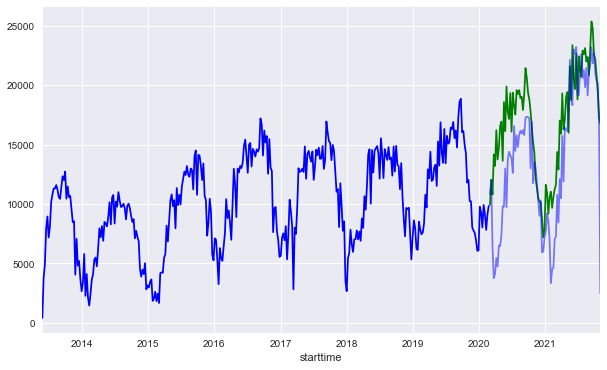

In [31]:
# Test plotting functionality

plot_results(df_dict['Clinton'], 
             df_preds.loc[:,'Clinton'], False)

## ARIMA tuning

- I will attempt to tune models with an R2 below 0.25

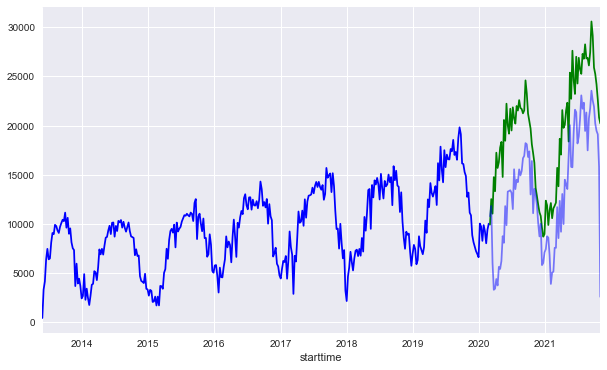

In [32]:
# Basline model plot

plot_results(df_dict['Chinatown'], 
             df_preds.loc[:,'Chinatown'], False)

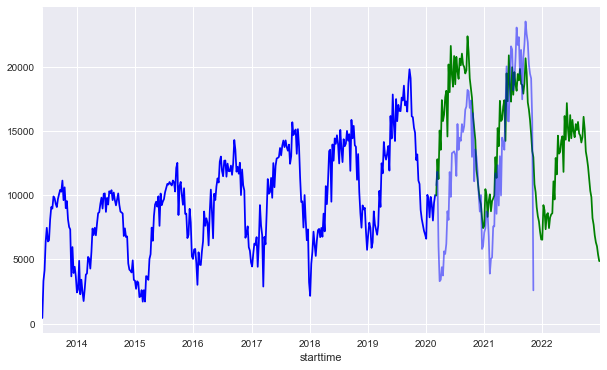

In [34]:
# Updating differencing term to 2 eliminates the upward trend in the data. Not suitable for outer year forecasting.

chinatown = df_dict['Chinatown']

chinatown_train = chinatown[chinatown['future'] == 0]
chinatown_test = chinatown[chinatown['future'] == 1]

sari_model = SARIMAX(chinatown_train['ride_count_log'], order=(1, 2, 1), seasonal_order=(1, 1, 0, 52)).fit()

plot_results(chinatown, sari_model.forecast(steps = len(chinatown_test) + 60), True)

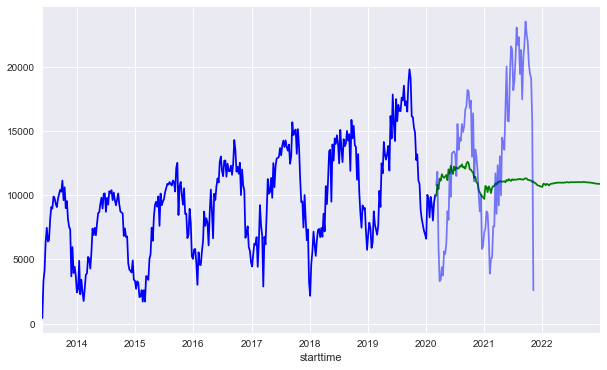

In [35]:
# Updating differencing term to 2 eliminates the upward trend in the data. Not suitable for outer year forecasting.

chinatown = df_dict['Chinatown']

chinatown_train = chinatown[chinatown['future'] == 0]
chinatown_test = chinatown[chinatown['future'] == 1]

sari_model = SARIMAX(chinatown_train['ride_count_log'], order=(3, 1, 1), seasonal_order=(1, 0, 0, 52)).fit()

plot_results(chinatown, sari_model.forecast(steps = len(chinatown_test) + 60), True)

There doesn't appear to be another combination of ordering that results in the model performing better.

## Adjust Train / Test split times

- For the neighborhoods that haven't experienced a faster post-COVID recovery in bike ridership, try adjusting the train / test split to see if incorporating COVID data helps performance

Repeat cleaning steps from up above, but just adjust the "future" cutoff

In [22]:
# Process each of the DFs in the neighborhood list

df_dict_covid = {}

for neighborhood in neighborhood_list:
    df = process_neighborhood(df_citibike, neighborhood)
    df_dict_covid[neighborhood] = df

In [23]:
# Resample for weekly given better performance of overall model on weekly data

for neighborhood, df in df_dict_covid.items():
    df_dict_covid[neighborhood] = df[['ride_count']].resample('W-SAT').sum()

In [24]:
# Add future column to define train and test periods

test_start_covid = '2020-11-01'

for neighborhood, df in df_dict_covid.items():
    
    df['future'] = (df.index >= test_start_covid).astype('int')
    
    df_dict_covid[neighborhood] = df

In [25]:
# Create a dataframe to store neighborhood by neighborhood results

df_results_covid = pd.DataFrame(index=neighborhood_list, columns=['model', 'order', 'seasonal_order',
                                                                  'explained_variance', 'MAE', 'MSE', 'R2',
                                                                  '2021_actual', '2021_predicted', 'delta', 
                                                                  'requires_log'])

In [26]:
# Create another dataframe to store the predictions from each model

df_preds_covid = pd.DataFrame(index=df_dict_covid['Clinton'][df_dict_covid['Clinton'].index >= test_start].index, 
                              columns=neighborhood_list)

In [27]:
# I know from before that I will want to log transform the columns. Skipping the part where I test the trend

for neighborhood, df in df_dict_covid.items():

    df_results_covid.loc[neighborhood, 'requires_log'] = True
    df['ride_count_log'] = df['ride_count'].apply(lambda x: np.log(x))
    df_dict_covid[neighborhood] = df

In [42]:
# Run models for each neighborhood. Use parameters that performed best on overall model.

for neighborhood, df in df_dict_covid.items():
    df_results_covid, df_preds_covid = run_model(df_results_covid, df_preds_covid, neighborhood, df, 
                                                 (3, 1, 1), (1, 0, 1, 52), 
                                                 df_results.loc[neighborhood, 'requires_log'])

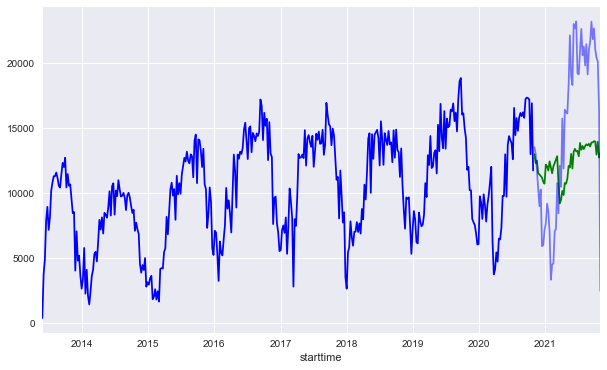

In [43]:
plot_results(df_dict_covid['Clinton'], 
             df_preds_covid.loc[:,'Clinton'], False)

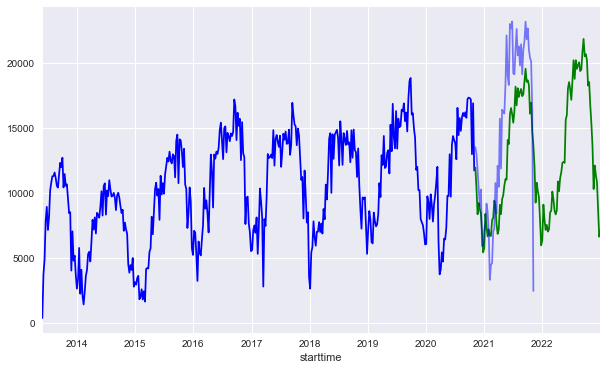

In [44]:
# Try testing various model combinations on Clinton

df_clinton_covid = df_dict_covid['Clinton']

clinton_train = df_clinton_covid[df_clinton_covid['future'] == 0]
clinton_test = df_clinton_covid[df_clinton_covid['future'] == 1]

clinton_model = SARIMAX(clinton_train['ride_count_log'], order=(3, 1, 1), seasonal_order=(1, 1, 1, 52)).fit()

plot_results(df_clinton_covid, clinton_model.forecast(steps = len(clinton_test) + 60), True)

In [97]:
# Grid search on Clinton

p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(clinton_train['ride_count_log'], 
                        order=param,
                        seasonal_order=param_seasonal).fit(maxiter=1000)
            results = mod.aic
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results))
        except: 
            print('Model Error!')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:164.29515040117934
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:108.90099111115902
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:145.5055564338819
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:105.53954457876124
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:117.23834171915581
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:70.24533629145078
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:96.65018166349662
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:69.11083065783211
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:126.90111189732221
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:72.88487084901432
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:106.17045216071108
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:71.52426412993665
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:117.8910890238876
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:72.12472395839784
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:97.9464528965915
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:71.00364737328869


Lowest AIC actually doesn't have an AR term. Will sense check this result

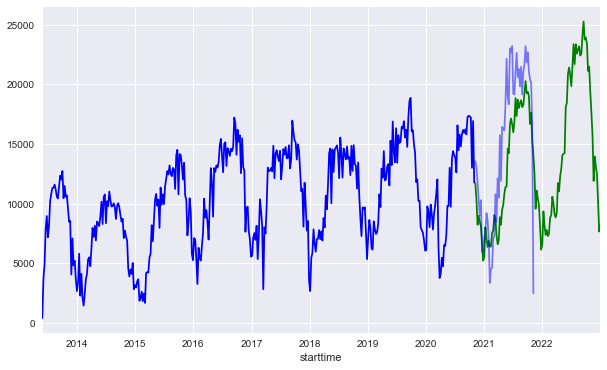

In [46]:
# Test best ARIMA from grid search on Clinton

df_clinton_covid = df_dict_covid['Clinton']

clinton_train = df_clinton_covid[df_clinton_covid['future'] == 0]
clinton_test = df_clinton_covid[df_clinton_covid['future'] == 1]

clinton_model2 = SARIMAX(clinton_train['ride_count_log'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 52)).fit()

plot_results(df_clinton_covid, clinton_model2.forecast(steps = len(clinton_test) + 60), True)

Actually a bit better without the AR Term. Will run a grid search on all the neighborhoods to find the best orders.

### Neighborhood grid search

In [22]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

print(pdq, seasonal_pdq)

[(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)] [(0, 1, 0, 52), (0, 1, 1, 52), (1, 1, 0, 52), (1, 1, 1, 52)]


In [56]:
df_grid_search = pd.DataFrame(index=neighborhood_list, columns=['order', 's_order', 'aic'])

In [57]:
df_grid_search.head()

,order,s_order,aic
Clinton,NaN,NaN,NaN
SoHo-TriBeCa-Civic Center-Little Italy,NaN,NaN,NaN
Chinatown,NaN,NaN,NaN
Fort Greene,NaN,NaN,NaN
Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN,NaN


In [58]:
def neighborhood_grid_search(pdq, seasonal_pdq, neighborhood, df, df_grid_search):
    
    # Set AIC to some high number to ensure at least one model is below
    best_aic = 10000000
    
    print(f"Currently working on: {neighborhood}")

    for param in pdq:
        for param_seasonal in seasonal_pdq: 
            mod = SARIMAX(df['ride_count_log'], order=param, seasonal_order=param_seasonal).fit(maxiter=1000)
                
            if mod.aic < best_aic:
                best_aic = mod.aic
                best_order = param
                best_s_order = param_seasonal
                df_grid_search.loc[neighborhood,:] = [best_order, best_s_order, best_aic]
    
    return df_grid_search

In [59]:
for neighborhood, df in df_dict_covid.items():
    df_grid_search = neighborhood_grid_search(pdq, seasonal_pdq, neighborhood, df, df_grid_search)

Currently working on: Clinton


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: SoHo-TriBeCa-Civic Center-Little Italy


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Chinatown


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Fort Greene


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Hudson Yards-Chelsea-Flatiron-Union Square


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Bedford


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: West Village


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Midtown-Midtown South


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Brooklyn Heights-Cobble Hill


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Lower East Side


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Murray Hill-Kips Bay


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Turtle Bay-East Midtown


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Battery Park City-Lower Manhattan


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: East Village


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Clinton Hill


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Sunset Park West


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: North Side-South Side


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Gramercy


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: park-cemetery-etc-Brooklyn


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Carroll Gardens-Columbia Street-Red Hook


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Lincoln Square


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Park Slope-Gowanus


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Stuyvesant Town-Cooper Village


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: park-cemetery-etc-Manhattan


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Lenox Hill-Roosevelt Island


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Upper East Side-Carnegie Hill


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Hunters Point-Sunnyside-West Maspeth


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Queensbridge-Ravenswood-Long Island City


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Greenpoint


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: East Williamsburg


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Williamsburg


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Bushwick South


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Stuyvesant Heights


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Upper West Side


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Yorkville


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: East Harlem South


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converg

Currently working on: Morningside Heights


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nest

Currently working on: Prospect Heights


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive param

In [29]:
# Save the results so we don't have to re-run the 3 hour long function again

# df_grid_search.to_csv('./results/neighborhood_grid_search.csv')

# If needed, load neighborhood grid search (if not running full notebook)

df_grid_search = pd.read_csv('./../results/neighborhood_grid_search.csv', index_col=0)

# Convert order / s_orders string via literal eval
df_grid_search['order'] = df_grid_search['order'].apply(lambda x: literal_eval(x))
df_grid_search['s_order'] = df_grid_search['s_order'].apply(lambda x: literal_eval(x))

In [30]:
# Print results

df_grid_search

# Seems to have a decent mix of best performing orders although it's interesting that most don't have the P
# term for the seasonal order

,order,s_order,aic
Clinton,"(0, 1, 1)","(0, 1, 1, 52)",106.136912
SoHo-TriBeCa-Civic Center-Little Italy,"(0, 1, 1)","(0, 1, 1, 52)",168.483082
Chinatown,"(1, 1, 0)","(0, 1, 1, 52)",60.125254
Fort Greene,"(1, 1, 0)","(1, 1, 1, 52)",80.233611
Hudson Yards-Chelsea-Flatiron-Union Square,"(0, 1, 1)","(0, 1, 1, 52)",147.795101
Bedford,"(0, 1, 1)","(0, 1, 1, 52)",71.333359
West Village,"(1, 1, 0)","(1, 1, 1, 52)",149.673825
Midtown-Midtown South,"(1, 1, 0)","(0, 1, 1, 52)",176.806083
Brooklyn Heights-Cobble Hill,"(0, 1, 1)","(0, 1, 1, 52)",155.443883
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,"(0, 1, 1)","(0, 1, 1, 52)",143.381195


In [36]:
# Rerun COVID training models with the best orders / seasonal orders

for neighborhood, df in df_dict_covid.items():
    df_results_covid, df_preds_covid = run_model(df_results_covid, df_preds_covid, neighborhood, df, 
                                                 df_grid_search.loc[neighborhood,'order'], 
                                                 df_grid_search.loc[neighborhood,'s_order'], 
                                                 df_results_covid.loc[neighborhood, 'requires_log'])

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using

In [37]:
df_results_covid

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Clinton,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.726332,3812.31,4452.96,0.513537,706840,0,706840,True
SoHo-TriBeCa-Civic Center-Little Italy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.778551,7241.18,8560.74,0.566014,1266160,0,1266160,True
Chinatown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.807424,2499.67,3217.61,0.719602,676262,0,676262,True
Fort Greene,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.710188,1745.32,2073.3,0.464661,309627,0,309627,True
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.655583,14529.1,16987.1,0.270047,2190634,0,2190634,True
Bedford,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.403573,1161.89,1484.88,0.267971,207296,0,207296,True
West Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.783835,8948.19,10715.5,0.609107,1571664,0,1571664,True
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.499271,13330,15330.1,-0.297083,1562113,0,1562113,True
Brooklyn Heights-Cobble Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.721584,1649.28,1916.74,0.344719,247070,0,247070,True
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.795017,2881.96,3392.43,0.561301,537851,0,537851,True


In [38]:
# Take a closer look at neighborhoods with poor performance to see if we can't tune them manually

r2_threshold = 0.25

df_tune = df_results_covid[df_results_covid.loc[:,'R2'] < r2_threshold]

In [40]:
# There are only 5 stations that have an R2 below the predefined threshold. 

df_tune

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.499271,13330,15330.1,-0.297083,1562113,0,1562113,True
Murray Hill-Kips Bay,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.553169,4560.34,5438.74,0.168539,754790,0,754790,True
Turtle Bay-East Midtown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.602439,5704.56,6629.08,0.041522,753899,0,753899,True
East Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.623278,8779.65,10416.3,0.052337,1116657,0,1116657,True
Sunset Park West,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(1, 1, 1, 52)",0.227926,515.131,797.238,-0.178518,47977,0,47977,True
park-cemetery-etc-Brooklyn,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(0, 1, 1, 52)",-0.100805,1376.07,1738.63,-0.211227,167600,0,167600,True
Carroll Gardens-Columbia Street-Red Hook,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",-1.41222,2799.86,3578.15,-1.89681,243325,0,243325,True
Lincoln Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",-0.00944689,3791.18,4785.83,-0.149983,547137,0,547137,True
Park Slope-Gowanus,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",-0.98994,5126.35,6501.24,-1.19646,263480,0,263480,True
Lenox Hill-Roosevelt Island,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(0, 1, 1, 52)",-0.944961,4045.97,5534.56,-1.11147,531047,0,531047,True


In [43]:
df_preds_covid.head()

,Clinton,SoHo-TriBeCa-Civic Center-Little Italy,Chinatown,Fort Greene,Hudson Yards-Chelsea-Flatiron-Union Square,Bedford,West Village,Midtown-Midtown South,Brooklyn Heights-Cobble Hill,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,...,Greenpoint,East Williamsburg,Williamsburg,Bushwick South,Stuyvesant Heights,Upper West Side,Yorkville,East Harlem South,Morningside Heights,Prospect Heights
starttime,,,,,,,,,,,,,,,,,,,,,
2020-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


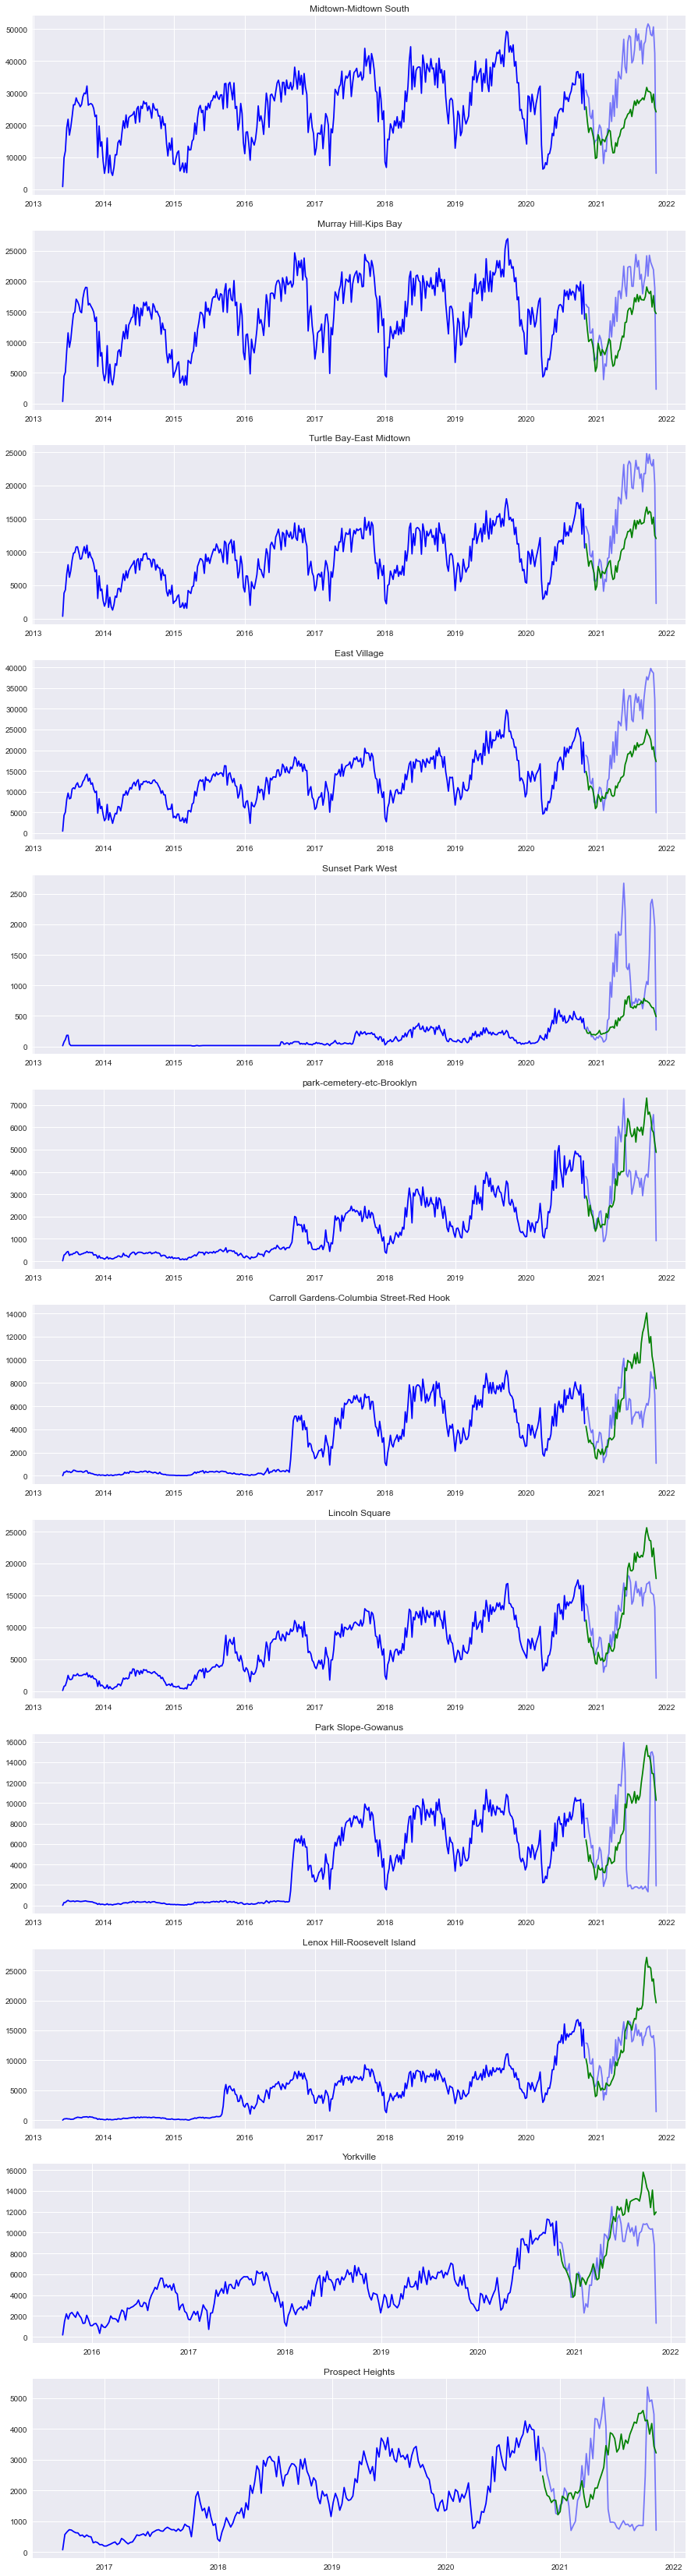

In [46]:
# Plot each of the predictions from these neighborhoods to sense check the results

# Midtown-Midtown South

fig, ax = plt.subplots(nrows=(len(df_tune.index)), figsize=(15,60))

for i, neighborhood in enumerate(df_tune.index):
    ax[i].plot(df_dict_covid[neighborhood].loc[df_dict_covid[neighborhood].future == 0, 'ride_count'], color='blue')
    ax[i].plot(df_dict_covid[neighborhood].loc[df_dict_covid[neighborhood].future == 1, 'ride_count'], color='blue', 
               alpha=0.5)
    
    ax[i].plot(df_preds_covid.loc[:,neighborhood], color='green')
    ax[i].set_title(neighborhood)


#### Neighborhood level tuning conclusions:
- There are a few neighborhoods, mostly in Manhattan, where the model "under-predicts" ridership, likely because it has no way to anticipate the surge in ridership from people coming back into the office
    - Midtown-Midtown South, Murray Hill-Kips Bay, Turtle Bay-East Midtown, East Village
- The second category of miss is those neighborhoods with an apparent data issue. During the summer of 2021, ridership falls off for a few Brooklyn neighborhoods, which appears to be a data issue. These are:
    - Propect Heights, Park Slope-Gowanus, Carrol Gardens, Park Cemetery, Brooklyn.
- Sunset Park west appears to have the opposite problem with a suspcious dual spike in ridership.

#### Next steps:
- Attempt to further tune the Manhattan neighborhoods
- Don't tune the neighborhoods with data issues any further

#### Manhattan neighborhood tuning
- Testing whether we can manually tune some of the Manhattan neighborhoods to improve COVID performance

In [47]:
# TBD

## Generate 2022 forecast
- The final piece will be to create a 2022 forecast for overall ridership and each of the neighborhoods
- TBD

## Incorporate exogenous COVID variables

- For the neighborhood files, I need to control for lower ridership due to COVID.
- Re-do the train / test split with some COVID data to train the index
- Incorporate the weekly COVID tracker (backfilled with values of 100 for each period prior to 2020)

In [24]:
# Read in the COVID data

covid_df = pd.read_csv('./covid_data/data-uIenF.csv')

In [25]:
# Preview the head of the data

covid_df.head()

,Date,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index
0,2020-01-04,16.7,16.8,14.6,16.1,15.8,16.7
1,2020-01-11,16.7,15.5,19.4,16.1,16.9,16.7
2,2020-01-18,16.7,15.5,19.0,16.2,16.7,16.7
3,2020-01-25,16.7,16.2,17.9,16.6,17.3,16.7
4,2020-02-01,16.7,18.4,18.2,16.3,17.2,16.7


In [26]:
# Convert the axis to datetime and create a "overall_index" column

covid_df['Date'] = pd.to_datetime(covid_df['Date'])

covid_df.set_index('Date', inplace=True)

covid_df['overall_index'] = covid_df.sum(axis=1)

In [27]:
# Sense check the results

covid_df.head(2)

,Covid-19 Hospitalizations Index,Unemployment Claims Index,Home Sales Index,Rental Inventory Index,Subway Mobility Index,Restaurant Reservations Index,overall_index
Date,,,,,,,
2020-01-04,16.7,16.8,14.6,16.1,15.8,16.7,96.7
2020-01-11,16.7,15.5,19.4,16.1,16.9,16.7,101.3


In [28]:
# Need to index on 'W-SAT' for the dates to line up

weekly_ridership = df_citibike.resample('W-SAT').sum()

weekly_ridership[weekly_ridership.index > '12/31/2019'].head()

,lat,long,ride_count,year
starttime,,,,
2020-01-04,241980.497558,-439433.137573,182595,11998305
2020-01-11,247560.331465,-449564.677521,305944,12277560
2020-01-18,247192.471613,-448899.513908,293624,12259380
2020-01-25,247110.350304,-448751.027035,248305,12255340
2020-02-01,247517.860672,-449490.762316,307286,12275540


In [52]:
# Test incorporating the COVID data into each of the neighborhood dataframes

df_clinton[df_clinton.index > '12/31/2019']

,ride_count,future,ride_count_log
starttime,,,
2020-01-04,6092,0,8.714732
2020-01-11,9772,0,9.187276
2020-01-18,9292,0,9.136909
2020-01-25,8024,0,8.990192
2020-02-01,9922,0,9.202510
...,...,...,...
2021-10-09,21060,1,9.955131
2021-10-16,20418,1,9.924172
2021-10-23,20144,1,9.910662


### Scratchwork below (attempting to systematically identify seasonality)

In [31]:
# df_clinton = df_dict['Clinton']

In [32]:
# df_clinton['ride_count'].plot();

In [33]:
# df_clinton.head(1)

In [34]:
# df_clinton.plot();

In [35]:
# df_clinton.drop('fft', axis=1, inplace=True)

In [36]:
# df_clinton['future'] = (df_clinton.index >= '2020-03-31').astype('int')

# df_clinton.insert(0, 't', range(len(df_clinton)))

In [37]:
# df_clinton.tail()

In [38]:
# X_train = df_clinton.loc[df_clinton.future == 0, 't'].values.reshape(-1, 1)
# X_test = df_clinton.loc[df_clinton.future == 1, 't'].values.reshape(-1, 1)

# # The train set is the actual value in the series
# y_train = df_clinton.loc[df_clinton.future == 0, 'ride_count'].values
# y_test = df_clinton.loc[df_clinton.future == 1, 'ride_count'].values

In [39]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds_lr = list(lr.predict(X_test))
# y_trend_lr = list(lr.predict(X_train))

In [40]:
# Add predictions to the dataframe

# df_clinton['preds'] = y_trend_lr + y_preds_lr
# df_clinton['resid'] = df_clinton['ride_count'] - df_clinton['preds']
# df_clinton.head()

In [41]:
# Create the Fourier transformation

# time = df_clinton['t']
# residuals = df_clinton['resid']

# fft_output = fft(residuals.values)
# power = np.abs(fft_output)
# freq = fftfreq(len(residuals))

In [42]:
# peaks = scipy.signal.find_peaks(power[freq >=0], prominence=10**4)[0]
# peak_freq = freq[peaks]
# peak_power = power[peaks]
# plt.plot(peak_freq, peak_power, 'ro');

In [43]:
# Plot results

# plt.figure(figsize=(10,6))
# plt.plot(df_clinton['ride_count'])
# plt.plot(df_clinton.loc[df_clinton.future == 0].index, y_trend_lr, color='orange')
# plt.plot(df_clinton.loc[df_clinton.future == 1].index, y_preds_lr, color='green')
# plt.show()

### Search for a systematic way to find seasonality

In [44]:
# df_clinton.head()

In [45]:
# seasonal = pd.DataFrame(decomposed_ts.seasonal, index=df_clinton.index, columns=['Seasonal Ridership'])

# seasonal

In [46]:
# for i, year in enumerate(list(seasonal.index.year.unique())):
#     if i == 2:
#         temp_df1 = seasonal[seasonal.index == year]
#         temp_df2 = seasonal[seasonal.index == year + 1]
        
#     if temp_df1['ride_count']

In [47]:
# pm.arima.nsdiffs(df_clinton['ride_count'].values, m=52)

In [48]:
# pmdarima.arima.nsdiffs()

In [49]:
# best_arima = SARIMAX(train_weekly2, order=(3, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()